In [ ]:
!pip install -q dm-haiku spektral optax neptune flax torch torch-geometric jraph wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 44.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB

In [ ]:
pip install -q -U jax jaxlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 MB 21.2 MB/s eta 0:00:00


In [ ]:
!pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
INFO: pip is looking at multiple versions of jax[cuda11-cudnn82] to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.4.10-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 MB 4.7 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439678 sha256=70d4f49c024c30a924c7dc98876

# Init


In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import neptune
import statistics
import itertools
import pickle
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple
import jraph
import haiku as hk
import functools
import time
import random

import numpy as np
from typing import Sequence
from spektral.utils import normalized_adjacency


# Torch Dataset related stuff
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import ZINC

from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader


# KGNN Models


## GIN

# Utils

## get_model(config: dict, hidden_channels: List[int]) -> Model, Params

196


## draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None

In [ ]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph

def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

# Dataset


## Loading Standard Dataset: 70/20/10 Split
X_train, y_train, adj_train

In [ ]:
# # Download jraph version of MUTAG.
# !wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
# with open('/tmp/mutag.pickle', 'rb') as f:
#   dataset = pickle.load(f)
# len(dataset)

--2023-05-13 09:50:57--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  1.29MB/s    in 0.3s    

2023-05-13 09:50:58 (1.29 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



188

In [ ]:
import pickle
import urllib.request
import random

vuln_list = ["delegatecall", "integeroverflow", "reentrancy", "timestamp"]

vuln_dataset = []

for vuln in vuln_list:
  url = f"https://github.com/Miyamura80/CFG_SCKGNN_Detect/raw/main/dataset/{vuln}_fixed.pkl"
  file_path = f"/tmp/{vuln}_fixed.pkl"
  urllib.request.urlretrieve(url, file_path)

  # Load the pickle file
  with open(file_path, "rb") as f:
      dataset_1 = pickle.load(f)
  vuln_dataset.append(dataset_1)

print(len(vuln_dataset))


In [ ]:
vuln_dataset[0][0]["target"]

[1]

In [ ]:
datasets = []
for i,ds in enumerate(vuln_dataset):
  main_ds = [d for d in ds]
  for j,ds_other in enumerate(vuln_dataset):
    if i!=j:
        for g in ds_other:
          graph = g["input_graph"]
          main_ds.append({"target": [0], "input_graph": graph})
  random.shuffle(main_ds)
  datasets.append(main_ds)

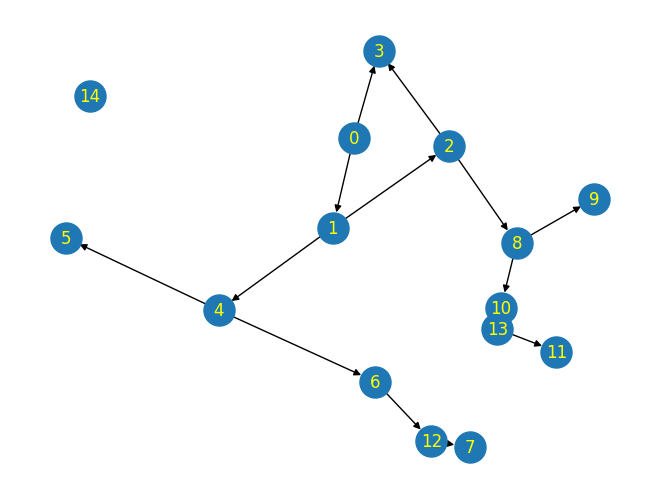

In [ ]:
draw_jraph_graph_structure(datasets[0][1]["input_graph"])

In [ ]:
dataset = datasets[3]
dataset = [g for g in dataset if g['input_graph'].edges.shape[0] > 0]

print(f"Target: {dataset[104]['target']}")

sum = 0
for g in dataset:
  sum += g["target"][0]
print(sum)


Target: [0]
349


In [ ]:
# Set the ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Calculate the number of samples for each set
n_samples = len(dataset)
n_train = int(train_ratio * n_samples)
n_valid = int(valid_ratio * n_samples)

train_ds = dataset[:n_train]
valid_ds = dataset[n_train:(n_train+n_valid)]
test_ds = dataset[(n_train+n_valid):]
print(n_train, n_valid)

762 217


In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

## padded_batch, labels, num_nodes, pad_nodes_to = create_padded_batch(train_ds)

In [ ]:
def create_padded_batch(ds):
  # for g in ds:
  #   print(g["input_graph"].edges.shape)
  ds_nodes_max = max([g["input_graph"].nodes.shape[0] for g in ds])
  ds_edges_max = max([g["input_graph"].edges.shape[0] for g in ds])

  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(ds_nodes_max))
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(ds_edges_max))
  print(jnp.sum(ds_edges_max))

  # padded_ds = [pad_graph_to_nearest_power_of_two(g["input_graph"]) for g in ds]
  padded_ds = [jraph.pad_with_graphs(g["input_graph"], pad_nodes_to, pad_edges_to) for g in ds]
  labels = jnp.array([g["target"] for g in ds])
  num_nodes = jnp.array([g["input_graph"].n_node for g in ds])
  return padded_ds, labels, num_nodes, pad_nodes_to

padded_batch, labels, num_nodes, pad_nodes_to = create_padded_batch(train_ds)
print([g.edges.shape for g in padded_batch])

71
[(128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 4), (128, 

# Training

## Setup



## Model

In [ ]:
class GNN:
    def __init__(self, hidden_dim, n_layers, n_classes=2):
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_classes = n_classes

    def update_node_fn(self, node, agg_send, agg_rec, globals_):
        node_update = jnp.concatenate([node, agg_send, agg_rec], axis=-1)
        net = hk.Sequential([hk.Linear(self.hidden_dim), jax.nn.relu,hk.Linear(self.hidden_dim)])
        return net(node_update)

    def update_edge_fn(self, edge, sender_node, receiver_node, globals_):
        edge_update = jnp.concatenate([edge, sender_node], axis=-1)
        # node_update = jnp.concatenate([node, agg_send, agg_rec], axis=-1)
        net = hk.Sequential([hk.Linear(self.hidden_dim), jax.nn.relu,hk.Linear(self.hidden_dim)])
        return net(edge_update)
        # return net(edge)

    def classifier_head(self, node, agg_send, agg_rec, globals_):
        node_update = jnp.concatenate([node, agg_send, agg_rec], axis=-1)
        net = hk.Sequential([hk.Linear(self.hidden_dim), jax.nn.relu,hk.Linear(self.n_classes)])
        return net(node_update)


    def build_layer(self, layer_num):
        if layer_num==self.n_layers-1:
            return jraph.GraphNetwork(
              update_node_fn=self.update_node_fn,
              update_edge_fn=self.update_edge_fn,
            )
        else:
            return jraph.GraphNetwork(
              update_node_fn=self.classifier_head,
              update_edge_fn=self.update_edge_fn,
            )

    def net_fn(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
        embedder = jraph.GraphMapFeatures(hk.Linear(self.hidden_dim), hk.Linear(self.hidden_dim), hk.Linear(self.hidden_dim))
        layers = [self.build_layer(layer_num) for layer_num in range(self.n_layers-1)]
        out_graph = embedder(graph)
        for layer in layers:
          out_graph = layer(out_graph)
        return out_graph



gin_model = GNN(64, 2)

graph_1 = train_ds[0]["input_graph"]
net_fn_partial = functools.partial(gin_model.net_fn, graph=graph_1)
net = hk.without_apply_rng(hk.transform(net_fn_partial))

rng = jax.random.PRNGKey(0)
params = net.init(rng)
pred_graph = net.apply(params)
print(pred_graph.nodes.shape)

# @jraph.concatenated_args
# def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
#   """Global update function for graph net."""
#   # MUTAG is a binary classification task, so output pos neg logits.
#   net = hk.Sequential([hk.Linear(FEAT), jax.nn.relu, hk.Linear(2)])
#   return net(feats)


/usr/local/lib/python3.10/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


(11, 2)


## Loss

### New loss

In [ ]:
def compute_dataset_loss(batched_graph: jraph.GraphsTuple, labels: jnp.ndarray,
                         params: hk.Params, net: hk.Transformed, n_graphs: int) -> Tuple[jnp.ndarray, jnp.ndarray]:

    updated_node_features = net.apply(params, batched_graph)
    feature_num = updated_node_features.nodes.shape[1]
    reshaped_features = updated_node_features.nodes.reshape((-1, pad_nodes_to, feature_num))

    summed_features = jnp.sum(reshaped_features, axis=1)
    preds = jax.nn.log_softmax(summed_features, axis=-1)

    targets = jax.nn.one_hot(labels.flatten(), num_classes=2)
    loss = -jnp.sum(targets * preds) / n_graphs
    acc = jnp.mean(jnp.equal(jnp.argmax(preds, axis=1), jnp.argmax(targets, axis=1)))

    return jnp.array(loss), jnp.array(acc)


## Junk


In [ ]:
gin_model = GNN(64, 2)

# Creating batched dataset
padded_batch, labels, num_nodes, pad_nodes_to = create_padded_batch(train_ds)
batched_graph = jraph.batch(padded_batch)


# Definitining haiku for training purpose
# net_fn_partial = functools.partial(gin_model.net_fn, graph=batched_graph)
# net = hk.without_apply_rng(hk.transform(net_fn_partial))
net = hk.without_apply_rng(hk.transform(gin_model.net_fn))


# GNN initialization + test inference
rng = jax.random.PRNGKey(0)
params = net.init(rng, batched_graph)
updated_node_features = net.apply(params, batched_graph)
print("updated_node_features", updated_node_features.nodes.shape)


compute_loss_fn = functools.partial(compute_dataset_loss,
                                    batched_graph=batched_graph,
                                    net=net,
                                    labels=labels,
                                    n_graphs=len(train_ds))



def wrapper_fn(params):
    return compute_loss_fn(params=params)

wrapper_fn = jax.jit(jax.value_and_grad(wrapper_fn, has_aux=True))
(loss, acc), grad = wrapper_fn(params)

print(loss)
print(acc)

updated_node_features (4192, 2)
0.8404377
0.35114503


## Train, Evaluate

In [ ]:
def train_epoch(params, opt_state, compute_loss_fn, opt_update):
    (loss, acc), grad = compute_loss_fn(params)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, acc


## train_and_eval

In [ ]:
def train_and_evaluate(config: dict, dataset: List[Dict[str, Any]], val_ds: List[Dict[str, Any]], neptune_client=None) -> hk.Params:

  # Creating batched dataset
  padded_batch, labels, num_nodes, pad_nodes_to = create_padded_batch(dataset)
  batched_train = jraph.batch(padded_batch)

  val_padded_batch, val_labels, val_num_nodes, val_pad_nodes_to = create_padded_batch(val_ds)
  batched_val = jraph.batch(val_padded_batch)

  # Initializing model
  model = GNN(config["hidden_channels"], config["num_layers"])
  net = hk.without_apply_rng(hk.transform(model.net_fn))
  rng_seed = 0
  neptune_client["params"]["rng_seed"] = rng_seed
  rng = jax.random.PRNGKey(rng_seed)
  rng, current_rng = jax.random.split(rng)
  params = net.init(rng, batched_train)

  # Early stopping measures
  best_acc_this_config = 0.0
  best_train_tracker = []
  best_state_this_config = None

  # Loss function
  compute_loss_fn = functools.partial(compute_dataset_loss,
                                    batched_graph=batched_train,
                                    net=net,
                                    labels=labels,
                                    n_graphs=len(dataset))
  def wrapper_fn(params):
    return compute_loss_fn(params=params)
  # jit the loss function for single XLA, jax.pmap for multi-XLA
  wrapper_fn = jax.jit(jax.value_and_grad(wrapper_fn, has_aux=True))
  (loss, acc), grad = wrapper_fn(params)


  # Validation loss function
  valid_loss_fn = functools.partial(compute_dataset_loss,
                                    batched_graph=batched_val,
                                    net=net,
                                    labels=val_labels,
                                    n_graphs=len(val_ds))
  def wrapper_fn_2(params):
    return valid_loss_fn(params=params)
  # jit the loss function for single XLA, jax.pmap for multi-XLA
  evaluate = jax.jit(wrapper_fn_2)


  for try_n in range(config["retry_num"]):
    # Re-initialize training state
    params = net.init(rng, batched_train)
    opt_init, opt_update = optax.adam(config["lr"]) if config["optimizer"]=="Adam" else optax.sgd(config["lr"], config["momentum"])
    opt_state = opt_init(params)
    rng, current_rng = jax.random.split(rng)

    # Early stopping parameters
    epochs_without_improvement = 0
    best_test_accuracy = 0.0
    best_model_state = None

    # List to store test accuracies
    try_train_tracker = []
    val_accuracies = []
    best_perform = True

    for idx in range(1, config["epoch"] + 1):

      params, opt_state, train_loss, train_accuracy = train_epoch(params, opt_state, wrapper_fn, opt_update)
      val_loss, val_accuracy = evaluate(params)

      val_accuracies.append(val_accuracy)
      # Update best test accuracy and model state
      if val_accuracy > best_test_accuracy:
          best_test_accuracy = val_accuracy
          best_model_state = params
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1

      # Early stopping
      if epochs_without_improvement >= config["early_stopping_threshold"]:
          best_perform = best_test_accuracy > best_acc_this_config
          print(f"Early stopping at epoch {idx}.")
          break

      # Log
      try_train_tracker.append({
          "train_loss": train_loss,
          "train_accuracy": train_accuracy,
          "val_accuracy": val_accuracy,
          "val_loss": val_loss,
      })

      if idx % 20 == 0:
          print(
              'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, val_loss: %.4f, val_accuracy: %.2f'
              % (idx, train_loss, train_accuracy * 100, val_loss,
                val_accuracy * 100))
    if best_perform:
        best_acc_this_config = best_test_accuracy
        best_model_this_config = best_model_state
        best_train_tracker = try_train_tracker

        neptune_client["params"]["best_val_accuracy"] = best_acc_this_config
        neptune_client["params"]["stop_epoch"] = idx
        val_acc_floats = [arr.item() for arr in val_accuracies]
        neptune_client["params"]["val_acc_std"] = statistics.stdev(val_acc_floats)
        best_perform = False

  # Plot the best run
  for i,epoch_detail in enumerate(best_train_tracker):
      neptune_client['train/train_loss'].append(epoch_detail["train_loss"])
      neptune_client['train/train_accuracy'].append(epoch_detail["train_accuracy"])
      neptune_client['train/val_loss'].append(epoch_detail["val_loss"])
      neptune_client['train/val_accuracy'].append(epoch_detail["val_accuracy"])

  neptune_client.stop()
  return best_state_this_config

## Main Loop

In [ ]:
lr_list = [0.001,0.0001]
num_layer_list = [2,3]
hidden_ch_list = [16,32,64,128]
# lr_list = [0.01]
# num_layer_list = [2]
# hidden_ch_list = [128]

prod_params = list(itertools.product(lr_list, num_layer_list,hidden_ch_list))

dataset_param_name = "timestamp"

first_datapoint = dataset[0]
edge_feat_dim = first_datapoint["input_graph"].nodes[0].shape[0]
node_feat_dim = first_datapoint["input_graph"].nodes[0].shape[0]

for (lr, n_layers,hidden_ch) in prod_params:
    run = neptune.init_run(
        project="miyamura80/Slither-Graph-CFG",
        api_token="",
        capture_hardware_metrics=True,
        capture_stderr=True,
        capture_stdout=True,
    )

    config = {"lr": lr,
              "optimizer": "SGD",
              "loss": "ce",
              "epoch": 300,
              "momentum": 0.9,
              "early_stopping_threshold": 100,
              "retry_num": 5,
              # Dataset Related,
              "dataset": dataset_param_name,
              # Model Related
              "model": "GIN",
              "num_layers": n_layers,
              "hidden_channels": hidden_ch,
              "in_channels": node_feat_dim,
              "edge_feat_dim": edge_feat_dim,
              "out_channels": 2,
              }
    run["parameters"] = config
    print("Parameters: ",(lr, n_layers,hidden_ch))
    params = train_and_evaluate(config, train_ds, valid_ds, run)

    run.stop()
    print("finished, submitting to neptune...")
    time.sleep(10)



https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-203
Parameters:  (0.001, 2, 16)
71
51
epoch: 20, train_loss: 1.8247, train_accuracy: 67.85, val_loss: 3.6267, val_accuracy: 64.06
epoch: 40, train_loss: 1.1508, train_accuracy: 67.85, val_loss: 1.9654, val_accuracy: 64.06
epoch: 60, train_loss: 0.9662, train_accuracy: 67.85, val_loss: 1.0826, val_accuracy: 64.06
epoch: 80, train_loss: 0.6410, train_accuracy: 66.80, val_loss: 0.7929, val_accuracy: 64.06
epoch: 100, train_loss: 0.6241, train_accuracy: 67.32, val_loss: 0.7314, val_accuracy: 64.06
epoch: 120, train_loss: 0.6207, train_accuracy: 67.32, val_loss: 0.7105, val_accuracy: 64.06
epoch: 140, train_loss: 0.6198, train_accuracy: 67.45, val_loss: 0.6971, val_accuracy: 64.06
epoch: 160, train_loss: 0.6192, train_accuracy: 67.45, val_loss: 0.6898, val_accuracy: 64.06
Early stopping at epoch 170.
epoch: 20, train_loss: 0.6513, train_accuracy: 67.85, val_loss: 0.9690, val_accuracy: 64.06
epoch: 40, train_loss: 0.6230, train_accur

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 230, in run
    super().run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 53, in run
    self.work()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 246, in work
    self.process_batch([element.obj for element in batch], batch[-1].ver)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 76, in wrapper
    result = func(self_, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 259, in process_batch
    processed_count, errors = self._processor._backend.exe



----NeptuneSynchronizationAlreadyStopped---------------------------------------------------

The synchronization thread had stopped before Neptune could finish uploading the logged metadata.
Your data is stored locally, but you'll need to finish the synchronization manually.
To synchronize with the Neptune servers, enter the following on your command line:

    neptune sync

For details, see https://docs.neptune.ai/api/neptune_sync/

If the synchronization fails, you may want to check your connection and ensure that you're
within limits by going to your Neptune project settings -> Usage.
If the issue persists, our support is happy to help.

Need help?-> https://docs.neptune.ai/getting_help

Explore the metadata in the Neptune app:
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-207/metadata
finished, submitting to neptune...
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-208
Parameters:  (0.001, 3, 32)
71
51
epoch: 20, train_loss: 54.7534, train_accuracy: 32.15

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 230, in run
    super().run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 53, in run
    self.work()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 246, in work
    self.process_batch([element.obj for element in batch], batch[-1].ver)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 76, in wrapper
    result = func(self_, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 259, in process_batch
    processed_count, errors = self._processor._backend.exe



----NeptuneSynchronizationAlreadyStopped---------------------------------------------------

The synchronization thread had stopped before Neptune could finish uploading the logged metadata.
Your data is stored locally, but you'll need to finish the synchronization manually.
To synchronize with the Neptune servers, enter the following on your command line:

    neptune sync

For details, see https://docs.neptune.ai/api/neptune_sync/

If the synchronization fails, you may want to check your connection and ensure that you're
within limits by going to your Neptune project settings -> Usage.
If the issue persists, our support is happy to help.

Need help?-> https://docs.neptune.ai/getting_help

Explore the metadata in the Neptune app:
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-208/metadata
finished, submitting to neptune...
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-209
Parameters:  (0.001, 3, 64)
71
51
epoch: 20, train_loss: nan, train_accuracy: 67.85, va

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 230, in run
    super().run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 53, in run
    self.work()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 246, in work
    self.process_batch([element.obj for element in batch], batch[-1].ver)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 76, in wrapper
    result = func(self_, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 259, in process_batch
    processed_count, errors = self._processor._backend.exe



----NeptuneSynchronizationAlreadyStopped---------------------------------------------------

The synchronization thread had stopped before Neptune could finish uploading the logged metadata.
Your data is stored locally, but you'll need to finish the synchronization manually.
To synchronize with the Neptune servers, enter the following on your command line:

    neptune sync

For details, see https://docs.neptune.ai/api/neptune_sync/

If the synchronization fails, you may want to check your connection and ensure that you're
within limits by going to your Neptune project settings -> Usage.
If the issue persists, our support is happy to help.

Need help?-> https://docs.neptune.ai/getting_help

Explore the metadata in the Neptune app:
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-209/metadata
finished, submitting to neptune...
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-210
Parameters:  (0.001, 3, 128)
71
51
epoch: 20, train_loss: nan, train_accuracy: 67.85, v

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 230, in run
    super().run()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 53, in run
    self.work()
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 246, in work
    self.process_batch([element.obj for element in batch], batch[-1].ver)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/threading/daemon.py", line 76, in wrapper
    result = func(self_, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/neptune/internal/operation_processors/async_operation_processor.py", line 259, in process_batch
    processed_count, errors = self._processor._backend.exe



----NeptuneSynchronizationAlreadyStopped---------------------------------------------------

The synchronization thread had stopped before Neptune could finish uploading the logged metadata.
Your data is stored locally, but you'll need to finish the synchronization manually.
To synchronize with the Neptune servers, enter the following on your command line:

    neptune sync

For details, see https://docs.neptune.ai/api/neptune_sync/

If the synchronization fails, you may want to check your connection and ensure that you're
within limits by going to your Neptune project settings -> Usage.
If the issue persists, our support is happy to help.

Need help?-> https://docs.neptune.ai/getting_help

Explore the metadata in the Neptune app:
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-210/metadata
finished, submitting to neptune...
https://app.neptune.ai/miyamura80/Slither-Graph-CFG/e/SLIT-211
Parameters:  (0.0001, 2, 16)
71
51
epoch: 20, train_loss: 0.6519, train_accuracy: 67.32

In [ ]:
!export NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyOTFjMWUxZi1iMWUyLTQ5YTctYmU3Yy05MWI4ZThlMjcyMDgifQ=="

In [ ]:
!neptune sync